In [31]:
# pip install xgboost

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

In [33]:
# ================================
# 2. Load and Inspect Data
# ================================
# Replace 'your_timeseries.csv' with your filename
df = pd.read_csv('./data/Outbound.csv', parse_dates=['OUTBOUND_DATE'], index_col='OUTBOUND_DATE')
df = df.dropna()
print(df.head())
print(df.info())


                    PLANT_NAME MODE_OF_TRANSPORT MATERIAL_NAME  \
OUTBOUND_DATE                                                    
2024-01-02     CHINA-WAREHOUSE             Truck      MAT-0013   
2024-01-02     CHINA-WAREHOUSE             Truck      MAT-0013   
2024-01-02     CHINA-WAREHOUSE             Truck      MAT-0268   
2024-01-02     CHINA-WAREHOUSE             Truck      MAT-0268   
2024-01-02     CHINA-WAREHOUSE             Truck      MAT-0268   

              CUSTOMER_NUMBER  NET_QUANTITY_MT  
OUTBOUND_DATE                                   
2024-01-02          CST-00001             25.5  
2024-01-02          CST-00001             25.5  
2024-01-02          CST-00002             25.5  
2024-01-02          CST-00002             25.5  
2024-01-02          CST-00002             25.5  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26990 entries, 2024-01-02 to 2025-01-02
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------          

In [34]:
# ================================
# 2.5. Encoding data
# ================================
le = LabelEncoder()
df['PLANT_NAME'] = le.fit_transform(df['PLANT_NAME'])
df['MODE_OF_TRANSPORT'] = le.fit_transform(df['MODE_OF_TRANSPORT'])
df['MATERIAL_NAME'] = le.fit_transform(df['MATERIAL_NAME'])
df['CUSTOMER_NUMBER'] = le.fit_transform(df['CUSTOMER_NUMBER'])

In [35]:
# ================================
# 3. Create Lag Features
# ================================
def create_lag_features(df, target_col, lags=[1, 2, 3]):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    df = df.dropna()
    return df

target_col = 'NET_QUANTITY_MT'  # Replace with your target column name
lags = [1, 2, 3, 7, 14]  # Example lags: daily & weekly

df = create_lag_features(df = df, target_col = target_col, lags = lags)

print(df.head())


               PLANT_NAME  MODE_OF_TRANSPORT  MATERIAL_NAME  CUSTOMER_NUMBER  \
OUTBOUND_DATE                                                                  
2024-01-02              0                  1            265                7   
2024-01-02              0                  1            269                8   
2024-01-02              0                  1            269                8   
2024-01-02              0                  1            283                9   
2024-01-02              0                  1             67               10   

               NET_QUANTITY_MT  NET_QUANTITY_MT_lag1  NET_QUANTITY_MT_lag2  \
OUTBOUND_DATE                                                                
2024-01-02               24.75                 24.75                 24.75   
2024-01-02               24.75                 24.75                 24.75   
2024-01-02               24.75                 24.75                 24.75   
2024-01-02               24.75                 24

In [36]:
# ================================
# Train/Test for CV: Use all data
# ================================
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (26976, 9), y shape: (26976,)


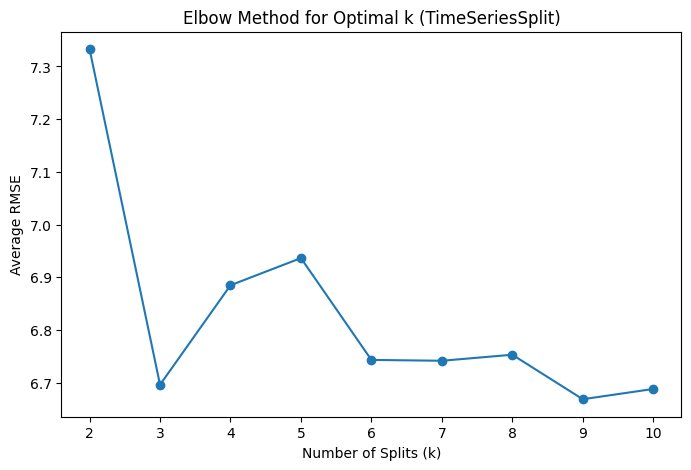

In [37]:
# ================================
# Elbow Method for TimeSeriesSplit
# ================================
rmse_scores = []
k_range = range(2, 11)  # Try k = 2 to 10

for k in k_range:
    tscv = TimeSeriesSplit(n_splits=k)
    fold_rmse = []
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            objective='reg:squarederror',
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        fold_rmse.append(rmse)
    rmse_scores.append(np.mean(fold_rmse))

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(k_range, rmse_scores, marker='o')
plt.title('Elbow Method for Optimal k (TimeSeriesSplit)')
plt.xlabel('Number of Splits (k)')
plt.ylabel('Average RMSE')
plt.show()


In [38]:
# ================================
# Use Optimal k for CV
# ================================
optimal_k = 3  # Replace with the k you choose from the elbow plot

tscv = TimeSeriesSplit(n_splits=optimal_k)
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.01,
        max_depth=3,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    print(f'Fold {fold+1} RMSE: {rmse:.4f}')

print(f'\nAverage CV RMSE: {np.mean(rmse_scores):.4f}')


Fold 1 RMSE: 7.5573
Fold 2 RMSE: 7.5081
Fold 3 RMSE: 7.1838

Average CV RMSE: 7.4164


In [39]:
# ================================
# Optional: Fit on all data
# ================================
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective='reg:squarederror',
    random_state=42
)
model.fit(X, y)

# If you have future data to predict:
# X_future = ... # Create features for future dates
# y_future_pred = model.predict(X_future)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [40]:
# ================================
# 7. Evaluate Model
# ================================
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'RMSE: {rmse:.4f}')


In [41]:
# ================================
# 8. Plot Predictions
# ================================
# plt.figure(figsize=(12, 6))
# plt.plot(y_test.index, y_test, label='Actual')
# plt.plot(y_test.index, y_pred, label='Predicted')
# plt.title('Actual vs Predicted')
# plt.xlabel('Date')
# plt.ylabel(target_col)
# plt.legend()
# plt.show()


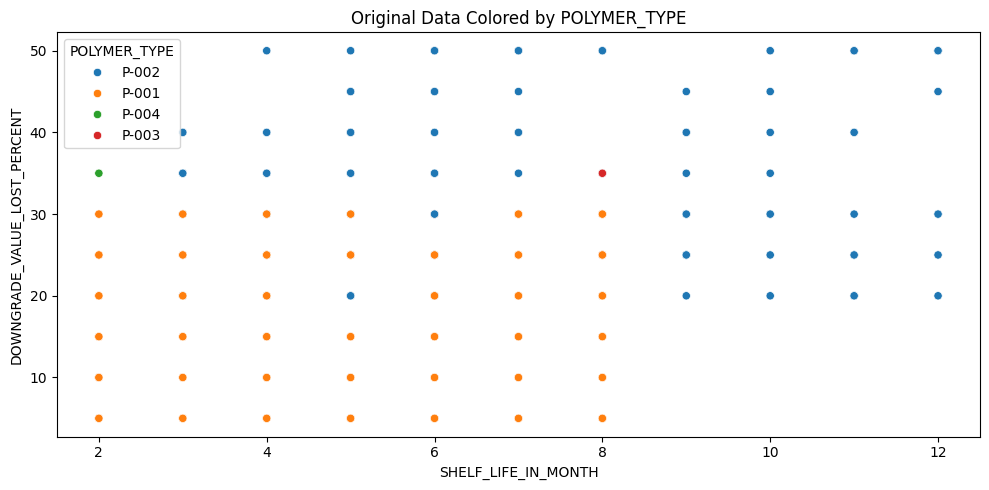

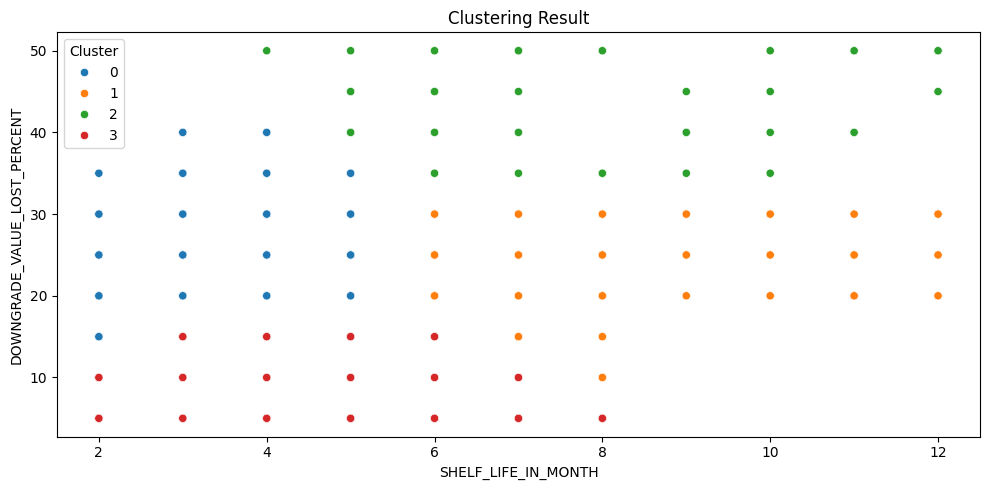

Clustered data saved to 'MaterialMaster_with_clusters.csv'.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# === 1. Load the data ===
df = pd.read_csv("./data/MaterialMaster.csv")

# === 2. Select relevant columns ===
features = ["SHELF_LIFE_IN_MONTH", "DOWNGRADE_VALUE_LOST_PERCENT"]
id_col = "MATERIAL_NAME"
color_col = "POLYMER_TYPE"

# Drop rows with missing values
df = df[[id_col] + features + [color_col]].dropna()

X = df[features].values

# === 3. Scale the data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 4. Fit KMeans ===
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# === 5. Plot original data ===
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df,
    x="SHELF_LIFE_IN_MONTH",
    y="DOWNGRADE_VALUE_LOST_PERCENT",
    hue="POLYMER_TYPE",
    palette="tab10"
)
plt.title("Original Data Colored by POLYMER_TYPE")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_LOST_PERCENT")
plt.legend(title="POLYMER_TYPE")
plt.tight_layout()
plt.show()

# === 6. Plot clustering result ===
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df,
    x="SHELF_LIFE_IN_MONTH",
    y="DOWNGRADE_VALUE_LOST_PERCENT",
    hue="Cluster",
    # style="POLYMER_TYPE",
    palette="tab10"
)
plt.title("Clustering Result")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_LOST_PERCENT")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# === 7. Save clustered data ===
df.to_csv("MaterialMaster_with_clusters.csv", index=False)
print("Clustered data saved to 'MaterialMaster_with_clusters.csv'.")


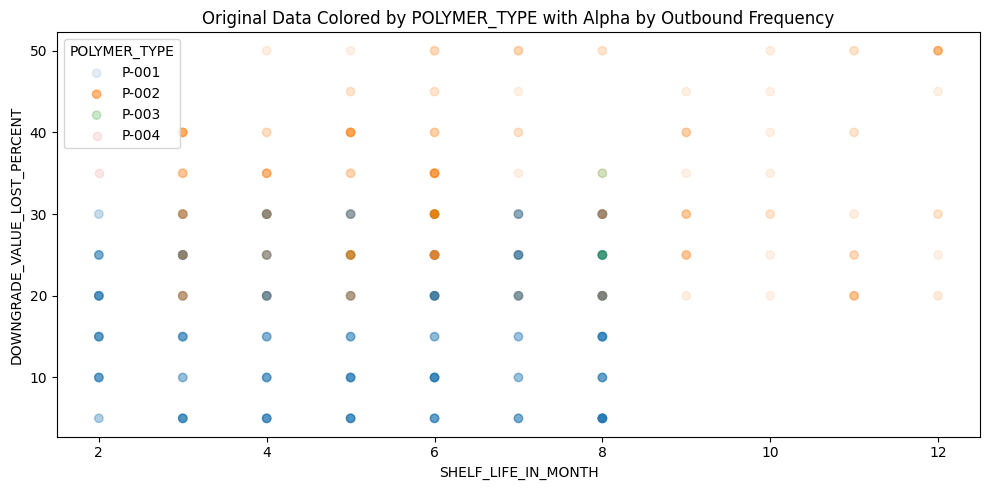

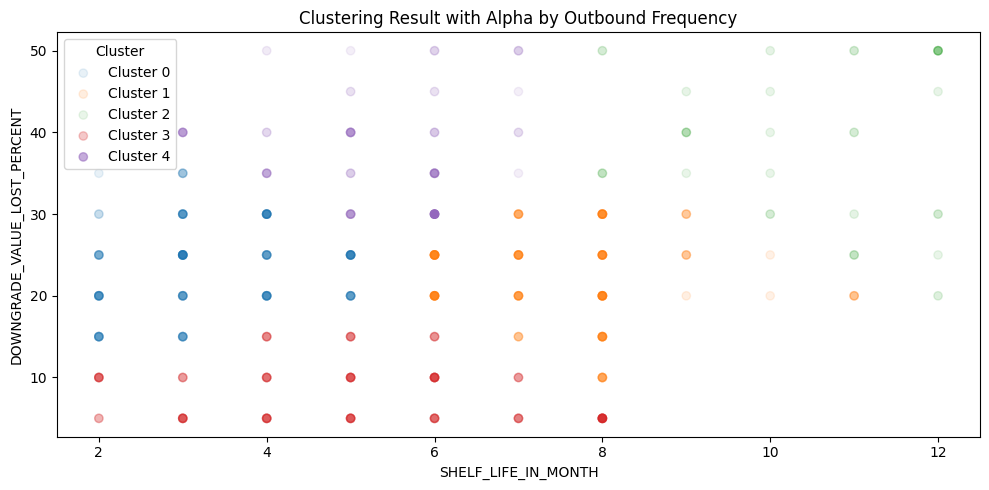

Clustered data saved to 'MaterialMaster_with_clusters.csv'.


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# === 1. Load the main MaterialMaster data ===
df = pd.read_csv("./data/MaterialMaster.csv")

# === 2. Load Outbound.csv to count MATERIAL_NAME frequencies ===
outbound = pd.read_csv("./data/Outbound.csv")

# === 3. Compute frequency of MATERIAL_NAME in Outbound.csv ===
freq = outbound["MATERIAL_NAME"].value_counts()

# === 4. Merge frequency into main dataframe ===
df["freq"] = df["MATERIAL_NAME"].map(freq).fillna(0)  # fill 0 if not found

# === 5. Normalize frequency to get alpha values in (0.1, 1) ===
if df["freq"].max() != df["freq"].min():
    df["alpha"] = (df["freq"] - df["freq"].min()) / (df["freq"].max() - df["freq"].min())
    df["alpha"] = df["alpha"] * 0.9 + 0.1
else:
    df["alpha"] = 0.5  # fallback if all freq same

# === 6. Select relevant columns ===
features = ["SHELF_LIFE_IN_MONTH", "DOWNGRADE_VALUE_LOST_PERCENT"]
id_col = "MATERIAL_NAME"
color_col = "POLYMER_TYPE"

# Drop rows with missing values
df = df[[id_col] + features + [color_col, "freq", "alpha"]].dropna()

X = df[features].values

# === 7. Scale the data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 8. Fit KMeans ===
kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# === 9. Plot original data with alpha ===
plt.figure(figsize=(10, 5))
for _, group in df.groupby(color_col):
    plt.scatter(
        group["SHELF_LIFE_IN_MONTH"],
        group["DOWNGRADE_VALUE_LOST_PERCENT"],
        alpha=group["alpha"],
        label=group[color_col].iloc[0]
    )
plt.title("Original Data Colored by POLYMER_TYPE with Alpha by Outbound Frequency")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_LOST_PERCENT")
plt.legend(title="POLYMER_TYPE")
plt.tight_layout()
plt.show()

# === 10. Plot clustering result with alpha ===
plt.figure(figsize=(10, 5))
for _, group in df.groupby("Cluster"):
    plt.scatter(
        group["SHELF_LIFE_IN_MONTH"],
        group["DOWNGRADE_VALUE_LOST_PERCENT"],
        alpha=group["alpha"],
        label=f"Cluster {group['Cluster'].iloc[0]}"
    )
plt.title("Clustering Result with Alpha by Outbound Frequency")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_LOST_PERCENT")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# === 11. Save clustered data ===
df.to_csv("MaterialMaster_with_clusters.csv", index=False)
print("Clustered data saved to 'MaterialMaster_with_clusters.csv'.")


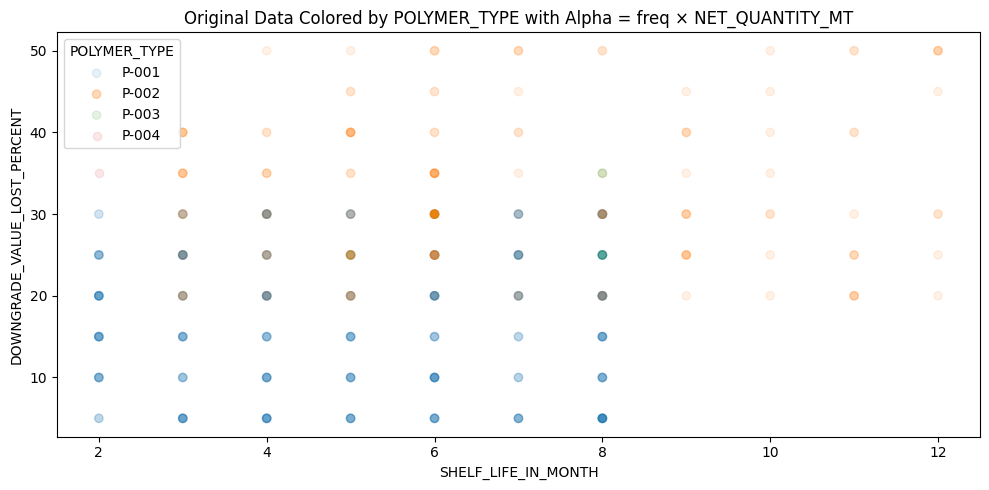

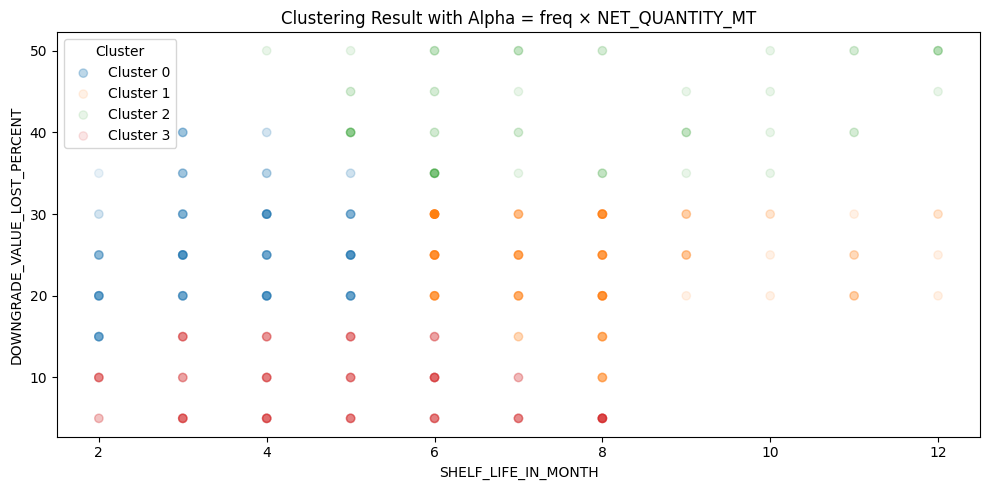

Clustered data saved to 'MaterialMaster_with_clusters.csv'.


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# === 1. Load the main MaterialMaster data ===
df = pd.read_csv("./data/MaterialMaster.csv")

# === 2. Load Outbound.csv ===
outbound = pd.read_csv("data/Outbound.csv")

# === 3. Calculate: freq × NET_QUANTITY_MT sum for each MATERIAL_NAME ===
# If you have multiple rows per MATERIAL_NAME, group by and aggregate
outbound["value"] = outbound.groupby("MATERIAL_NAME")["NET_QUANTITY_MT"].transform("sum")
outbound["freq"] = outbound.groupby("MATERIAL_NAME")["MATERIAL_NAME"].transform("count")
outbound["value"] = outbound["value"] * outbound["freq"]

# Keep unique MATERIAL_NAME with the computed value
outbound_value = outbound[["MATERIAL_NAME", "value"]].drop_duplicates()

# === 4. Map to main dataframe ===
df["value"] = df["MATERIAL_NAME"].map(outbound_value.set_index("MATERIAL_NAME")["value"]).fillna(0)

# === 5. Normalize to (0.1, 1) for alpha ===
if df["value"].max() != df["value"].min():
    df["alpha"] = (df["value"] - df["value"].min()) / (df["value"].max() - df["value"].min())
    df["alpha"] = df["alpha"] * 0.9 + 0.1
else:
    df["alpha"] = 0.5  # fallback if all same

# === 6. Select relevant columns ===
features = ["SHELF_LIFE_IN_MONTH", "DOWNGRADE_VALUE_LOST_PERCENT"]
id_col = "MATERIAL_NAME"
color_col = "POLYMER_TYPE"

# Drop rows with missing values
df = df[[id_col] + features + [color_col, "value", "alpha"]].dropna()

X = df[features].values

# === 7. Scale the data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 8. Fit KMeans ===
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# === 9. Plot original data with alpha ===
plt.figure(figsize=(10, 5))
for _, group in df.groupby(color_col):
    plt.scatter(
        group["SHELF_LIFE_IN_MONTH"],
        group["DOWNGRADE_VALUE_LOST_PERCENT"],
        alpha=group["alpha"],
        label=group[color_col].iloc[0]
    )
plt.title("Original Data Colored by POLYMER_TYPE with Alpha = freq × NET_QUANTITY_MT")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_LOST_PERCENT")
plt.legend(title="POLYMER_TYPE")
plt.tight_layout()
plt.show()

# === 10. Plot clustering result with alpha ===
plt.figure(figsize=(10, 5))
for _, group in df.groupby("Cluster"):
    plt.scatter(
        group["SHELF_LIFE_IN_MONTH"],
        group["DOWNGRADE_VALUE_LOST_PERCENT"],
        alpha=group["alpha"],
        label=f"Cluster {group['Cluster'].iloc[0]}"
    )
plt.title("Clustering Result with Alpha = freq × NET_QUANTITY_MT")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_LOST_PERCENT")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# === 11. Save clustered data ===
df.to_csv("MaterialMaster_with_clusters.csv", index=False)
print("Clustered data saved to 'MaterialMaster_with_clusters.csv'.")


In [32]:
# === 1. Load the main MaterialMaster data ===
df = pd.read_csv("./data/MaterialMaster_AVG_China.csv")

# === 2. Load Outbound.csv ===
outbound = pd.read_csv("./data/Outbound.csv")

In [33]:
import plotly.express as px

# Calculate IQR for total_price
Q1 = df['DOWNGRADE_VALUE_AVG_MT'].quantile(0.15)
Q3 = df['DOWNGRADE_VALUE_AVG_MT'].quantile(0.85)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['DOWNGRADE_VALUE_AVG_MT'] >= lower_bound) & (df['DOWNGRADE_VALUE_AVG_MT'] <= upper_bound)]

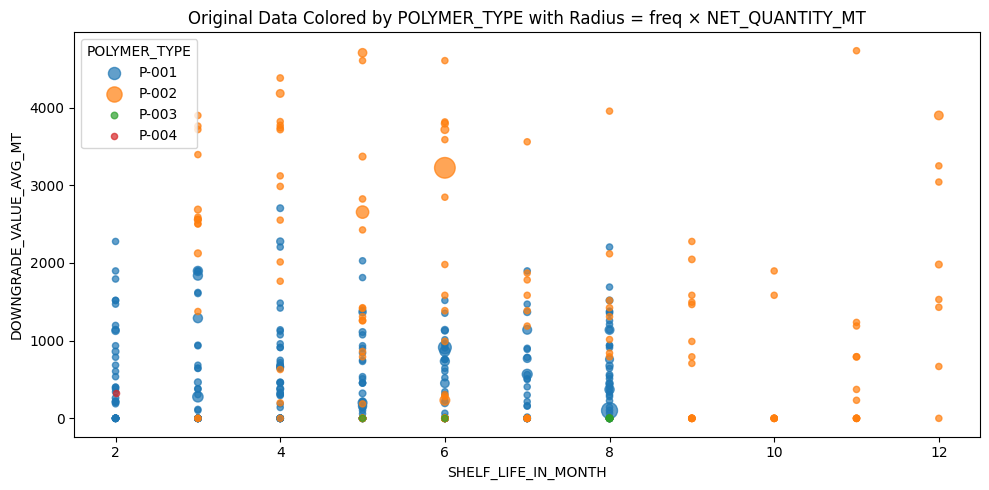

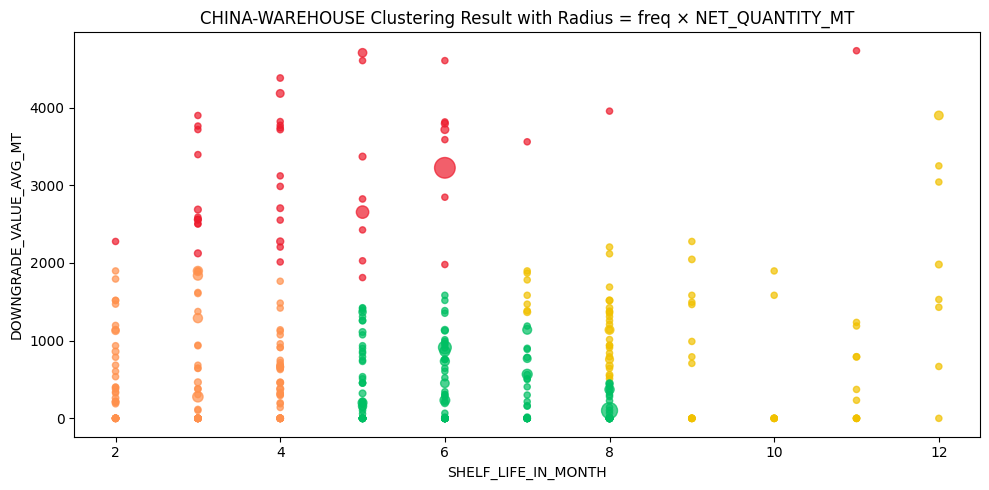

Clustered data saved to 'MaterialMaster_with_clusters_CHINA.csv'.


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



# === 3. Calculate: freq × NET_QUANTITY_MT for each MATERIAL_NAME ===
outbound["freq"] = outbound.groupby("MATERIAL_NAME")["MATERIAL_NAME"].transform("count")
outbound["quantity_sum"] = outbound.groupby("MATERIAL_NAME")["NET_QUANTITY_MT"].transform("sum")
outbound["value"] = outbound["freq"] * outbound["quantity_sum"]

# Keep unique MATERIAL_NAME with the computed value
outbound_value = outbound[["MATERIAL_NAME", "value"]].drop_duplicates()

# === 4. Merge value into main dataframe ===
df["value"] = df["MATERIAL_NAME"].map(outbound_value.set_index("MATERIAL_NAME")["value"]).fillna(0)

# === 5. Normalize value for point size (radius) ===
if df["value"].max() != df["value"].min():
    df["radius"] = (df["value"] - df["value"].min()) / (df["value"].max() - df["value"].min())
    df["radius"] = df["radius"] * 200 + 20
else:
    df["radius"] = 50

# === 6. Select relevant columns ===
features = ["SHELF_LIFE_IN_MONTH", "DOWNGRADE_VALUE_AVG_MT"]
id_col = "MATERIAL_NAME"
color_col = "POLYMER_TYPE"

df = df[[id_col] + features + [color_col, "value", "radius"]].dropna()
X = df[features].values

# === 7. Scale the data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 8. Fit KMeans ===
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# === 9. Define cluster colors ===
cluster_colors = {
    0: "#ff914d",
    1: "#f1c100",
    2: "#00bf63",
    3: "#ed1b2d",
}

# === 9b. Define your own custom cluster names ===
# UPDATE THIS DICT with your labels!
cluster_names = {
    0: "Critical Material",
    1: "Low Risk",
    2: "Aging but Valuable",
    3: "Perishable but Low Value",
}

# === 10. Add custom cluster name column ===
df["Cluster_Name"] = df["Cluster"].map(cluster_names)

# === 11. Plot original data ===
plt.figure(figsize=(10, 5))
for _, group in df.groupby(color_col):
    plt.scatter(
        group["SHELF_LIFE_IN_MONTH"],
        group["DOWNGRADE_VALUE_AVG_MT"],
        s=group["radius"],
        alpha=0.7,
        label=group[color_col].iloc[0]
    )
plt.title("Original Data Colored by POLYMER_TYPE with Radius = freq × NET_QUANTITY_MT")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_AVG_MT")
plt.legend(title="POLYMER_TYPE")
plt.tight_layout()
plt.show()

# === 12. Plot clustering result with radius and custom names ===
plt.figure(figsize=(10, 5))
for cluster, group in df.groupby("Cluster"):
    plt.scatter(
        group["SHELF_LIFE_IN_MONTH"],
        group["DOWNGRADE_VALUE_AVG_MT"],
        s=group["radius"],
        alpha=0.7,
        label=cluster_names.get(cluster, f"Cluster {cluster}"),
        color=cluster_colors.get(cluster, "#333333")
    )
plt.title("CHINA-WAREHOUSE Clustering Result with Radius = freq × NET_QUANTITY_MT")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_AVG_MT")
# plt.legend(title="Cluster Name")
plt.tight_layout()
plt.show()

# === 13. Save clustered data with custom names ===
df.to_csv("MaterialMaster_with_clusters_CHINA", index=False)
print("Clustered data saved to 'MaterialMaster_with_clusters_CHINA.csv'.")


In [35]:
# === 1. Load the main MaterialMaster data ===
df = pd.read_csv("./data/MaterialMaster_AVG_Singapore.csv")

# === 2. Load Outbound.csv ===
outbound = pd.read_csv("./data/Outbound.csv")

In [36]:
import plotly.express as px

# Calculate IQR for total_price
Q1 = df['DOWNGRADE_VALUE_AVG_MT'].quantile(0.15)
Q3 = df['DOWNGRADE_VALUE_AVG_MT'].quantile(0.85)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['DOWNGRADE_VALUE_AVG_MT'] >= lower_bound) & (df['DOWNGRADE_VALUE_AVG_MT'] <= upper_bound)]

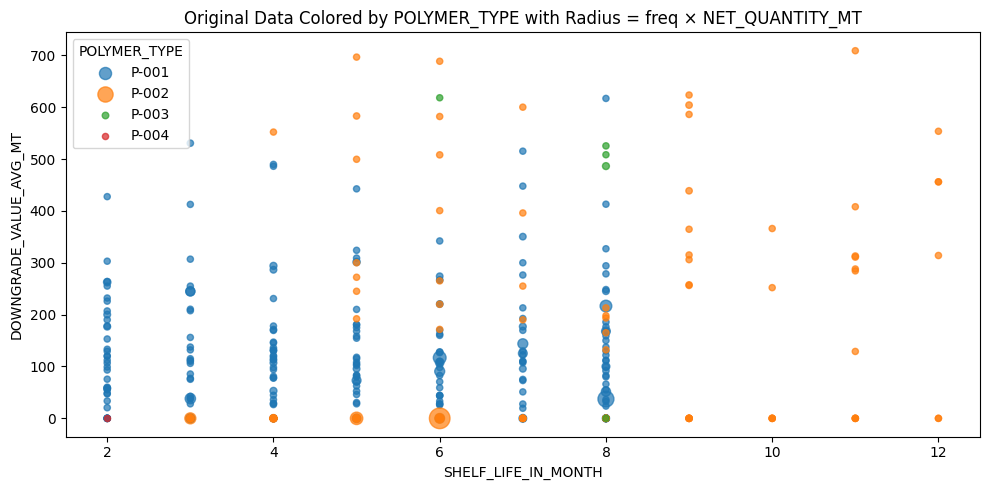

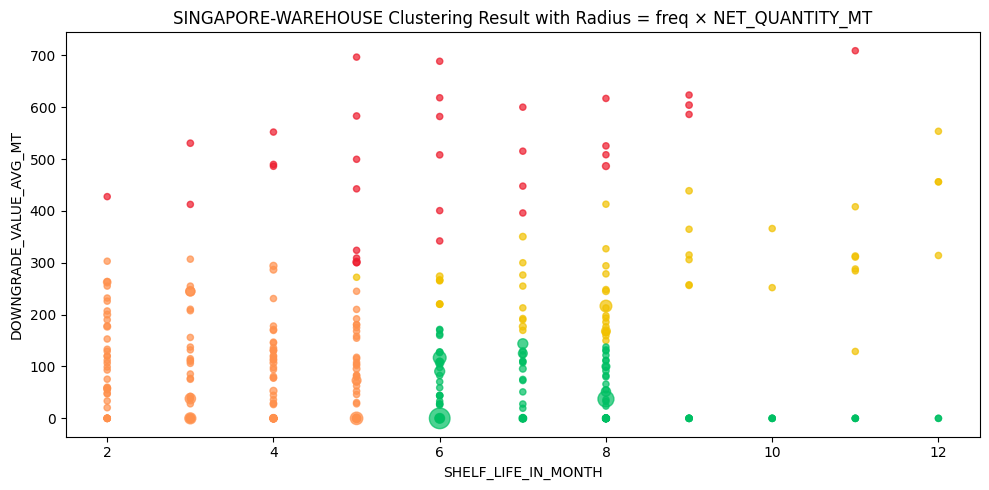

Clustered data saved to 'MaterialMaster_with_clusters_SINGAPORE.csv'.


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



# === 3. Calculate: freq × NET_QUANTITY_MT for each MATERIAL_NAME ===
outbound["freq"] = outbound.groupby("MATERIAL_NAME")["MATERIAL_NAME"].transform("count")
outbound["quantity_sum"] = outbound.groupby("MATERIAL_NAME")["NET_QUANTITY_MT"].transform("sum")
outbound["value"] = outbound["freq"] * outbound["quantity_sum"]

# Keep unique MATERIAL_NAME with the computed value
outbound_value = outbound[["MATERIAL_NAME", "value"]].drop_duplicates()

# === 4. Merge value into main dataframe ===
df["value"] = df["MATERIAL_NAME"].map(outbound_value.set_index("MATERIAL_NAME")["value"]).fillna(0)

# === 5. Normalize value for point size (radius) ===
if df["value"].max() != df["value"].min():
    df["radius"] = (df["value"] - df["value"].min()) / (df["value"].max() - df["value"].min())
    df["radius"] = df["radius"] * 200 + 20
else:
    df["radius"] = 50

# === 6. Select relevant columns ===
features = ["SHELF_LIFE_IN_MONTH", "DOWNGRADE_VALUE_AVG_MT"]
id_col = "MATERIAL_NAME"
color_col = "POLYMER_TYPE"

df = df[[id_col] + features + [color_col, "value", "radius"]].dropna()
X = df[features].values

# === 7. Scale the data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 8. Fit KMeans ===
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# === 9. Define cluster colors ===
cluster_colors = {
    0: "#ff914d",
    1: "#f1c100",
    2: "#00bf63",
    3: "#ed1b2d",
}

# === 9b. Define your own custom cluster names ===
# UPDATE THIS DICT with your labels!
cluster_names = {
    0: "Critical Material",
    1: "Low Risk",
    2: "Aging but Valuable",
    3: "Perishable but Low Value",
}

# === 10. Add custom cluster name column ===
df["Cluster_Name"] = df["Cluster"].map(cluster_names)

# === 11. Plot original data ===
plt.figure(figsize=(10, 5))
for _, group in df.groupby(color_col):
    plt.scatter(
        group["SHELF_LIFE_IN_MONTH"],
        group["DOWNGRADE_VALUE_AVG_MT"],
        s=group["radius"],
        alpha=0.7,
        label=group[color_col].iloc[0]
    )
plt.title("Original Data Colored by POLYMER_TYPE with Radius = freq × NET_QUANTITY_MT")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_AVG_MT")
plt.legend(title="POLYMER_TYPE")
plt.tight_layout()
plt.show()

# === 12. Plot clustering result with radius and custom names ===
plt.figure(figsize=(10, 5))
for cluster, group in df.groupby("Cluster"):
    plt.scatter(
        group["SHELF_LIFE_IN_MONTH"],
        group["DOWNGRADE_VALUE_AVG_MT"],
        s=group["radius"],
        alpha=0.7,
        label=cluster_names.get(cluster, f"Cluster {cluster}"),
        color=cluster_colors.get(cluster, "#333333")
    )
plt.title("SINGAPORE-WAREHOUSE Clustering Result with Radius = freq × NET_QUANTITY_MT")
plt.xlabel("SHELF_LIFE_IN_MONTH")
plt.ylabel("DOWNGRADE_VALUE_AVG_MT")
# plt.legend(title="Cluster Name")
plt.tight_layout()
plt.show()

# === 13. Save clustered data with custom names ===
df.to_csv("MaterialMaster_with_clusters_SINGAPORE.csv", index=False)
print("Clustered data saved to 'MaterialMaster_with_clusters_SINGAPORE.csv'.")
